# Neural Survival Clustering on SUPPORT Dataset

The SUPPORT dataset comes from the Vanderbilt University study
to estimate survival for seriously ill hospitalized adults.
(Refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
for the original datasource.)

In this notebook, we will apply Neural Survival Clustering on the SUPPORT data.

In [ ]:
import sys
sys.path.append('../')
sys.path.append('/content/gdrive/My Drive/NeuralSurvivalClustering/DeepSurvivalMachines/')
print(sys.executable)

/usr/bin/python3


In [ ]:
!pip install pyspark
!pip install nose
!pip install scikit-survival
!pip install pycox
!pip install tqdm
!pip install lifelines


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.3
    Uninstalling osqp-1.0.3:
      Successfully uninstalled osqp-1.0.3
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#!apt-get install -y build-essential
#!export SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=Tru
#!pip install sklearn==0.0
#!pip install pysurvival

In [ ]:
# View and modify the working path
import os
from google.colab import drive

# View current working directory
print("Current Working Directory:", os.getcwd())

# Mount Google Drive
drive.mount('/content/gdrive')

# Change working directory to your file position
path = "/content/gdrive/My Drive/NeuralSurvivalClustering"
os.chdir(path)

# Confirm the change
print("Working Directory:", os.getcwd())

Current Working Directory: /content
Mounted at /content/gdrive
Working Directory: /content/gdrive/My Drive/NeuralSurvivalClustering


### Load the SUPPORT Dataset

The package includes helper functions to load the dataset.

X represents an np.array of features (covariates),
T is the event/censoring times and,
E is the censoring indicator.

In [ ]:
from nsc import datasets
x, t, e, columns = datasets.load_dataset('SUPPORT')

In [ ]:
print(x.shape)
print(t.shape)
print(e.shape)


(9105, 44)
(9105,)
(9105,)


### Compute horizons at which we evaluate the performance of NSC

Survival predictions are issued at certain time horizons. Here we will evaluate the performance
of NSC to issue predictions at the 25th, 50th and 75th event time quantile as is standard practice in Survival Analysis.

In [ ]:
import numpy as np
import torch
np.random.seed(42)
torch.random.manual_seed(42)

horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e!=0], horizons).tolist()

In [ ]:
# Display the percentage of observed event at different time horizon
for time in times:
    print('At time {:.2f}'.format(time))
    for risk in np.unique(e):
        print('\t {:.2f} % observed risk {}'.format(100 * ((e == risk) & (t < time)).mean(), risk))

At time 15.00
	 0.00 % observed risk 0
	 16.71 % observed risk 1
At time 59.00
	 0.00 % observed risk 0
	 33.96 % observed risk 1
At time 253.00
	 0.00 % observed risk 0
	 51.03 % observed risk 1


### Splitting the data into train, test and validation sets

We will train NSC on 80% of the Data (10 % of which is used for stopping criterion and 10% for model Selection) and report performance on the remaining 20% held out test set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size = 0.2, random_state = 42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size = 0.2, random_state = 42)
x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size = 0.5, random_state = 42)

minmax = lambda x: x / t_train.max() # Enforce to be inferior to 1
t_train_ddh = minmax(t_train)
t_dev_ddh = minmax(t_dev)
t_val_ddh = minmax(t_val)
times_ddh = minmax(np.array(times))

### Setting the parameter grid

Lets set up the parameter grid to tune hyper-parameters. We will tune the number of underlying survival distributions,
($K$), the latent representation, the learning rate for the Adam optimizer and the number of hidden layers and nodes.

In [ ]:
from sklearn.model_selection import ParameterSampler

In [ ]:
layers = [[50], [50, 50], [50, 50, 50], [100], [100, 100], [100, 100, 100]]
param_grid = {
            'learning_rate' : [1e-3, 1e-4],
            'layers_surv': layers,
            'k': [2, 3, 4, 5],
            'representation': [50, 100],
            'layers' : layers,
            'act': ['Tanh'],
            'batch': [100, 250],
            }
params = ParameterSampler(param_grid, 10, random_state = 42)

### Model Training and Selection

In [ ]:
from nsc import NeuralSurvivalCluster

In [ ]:
models = []
for param in params:
    model = NeuralSurvivalCluster(layers = param['layers'], act = param['act'], k = param['k'],
                                layers_surv = param['layers_surv'], representation = param['representation'])
    # The fit method is called to train the model
    model.fit(x_train, t_train_ddh, e_train, n_iter = 10, bs = param['batch'],
            lr = param['learning_rate'], val_data = (x_dev, t_dev_ddh, e_dev))
    nll = model.compute_nll(x_val, t_val_ddh, e_val)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

Loss: -0.566: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


In [ ]:
best_model = min(models, key = lambda x: x[0])
model = best_model[1]

### Inference

Model prediction for the different patients and analysis of the results

In [ ]:
out_risk = model.predict_risk(x_test, times_ddh.tolist())
out_survival = model.predict_survival(x_test, times_ddh.tolist())

### Evaluation

We evaluate the performance of NSC in its discriminative ability (Time Dependent Concordance Index and Cumulative Dynamic AUC) as well as Brier Score.

In [ ]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [ ]:
et_train = np.array([(e_train[i] == 1, t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i] == 1, t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
selection = (t_test < t_train.max()) | (e_test == 0)

cis = []
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
brs = brier_score(et_train, et_test[selection], out_survival[selection], times)[1]
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.7371032915679696
Brier Score: 0.133666157500591
ROC AUC  0.7490319007532122 

For 0.5 quantile,
TD Concordance Index: 0.6938154431658189
Brier Score: 0.19876143822019493
ROC AUC  0.7151924393918642 

For 0.75 quantile,
TD Concordance Index: 0.6790433622544867
Brier Score: 0.21205898901381107
ROC AUC  0.724779849936066 



## Cluster analysis

In this section, we display the learnt clusters and the impact of the different features on the membership to each cluster. This importance is obtained through permutation of the feature.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
times_cluster = np.quantile(t, np.linspace(0, 1, 100))
clusters = model.survival_cluster(minmax(times_cluster).tolist(), 1)

In [ ]:
print(clusters)

[[9.47503692e-01 9.99637211e-01 9.95584313e-01]
 [9.47503692e-01 9.99637211e-01 9.95584313e-01]
 [9.34815847e-01 9.99546507e-01 9.94483024e-01]
 [9.34815847e-01 9.99546507e-01 9.94483024e-01]
 [9.34815847e-01 9.99546507e-01 9.94483024e-01]
 [9.22297840e-01 9.99455801e-01 9.93382786e-01]
 [9.22297840e-01 9.99455801e-01 9.93382786e-01]
 [9.09947400e-01 9.99365092e-01 9.92283599e-01]
 [8.97762283e-01 9.99274381e-01 9.91185461e-01]
 [8.97762283e-01 9.99274381e-01 9.91185461e-01]
 [8.85740278e-01 9.99183667e-01 9.90088373e-01]
 [8.85740278e-01 9.99183667e-01 9.90088373e-01]
 [8.73879203e-01 9.99092951e-01 9.88992333e-01]
 [8.62176902e-01 9.99002232e-01 9.87897341e-01]
 [8.50631253e-01 9.98911510e-01 9.86803395e-01]
 [8.46125518e-01 9.98875771e-01 9.86372734e-01]
 [8.28001551e-01 9.98730060e-01 9.84618640e-01]
 [8.16913389e-01 9.98639331e-01 9.83527830e-01]
 [8.05973660e-01 9.98548600e-01 9.82438063e-01]
 [7.84531582e-01 9.98367129e-01 9.80261656e-01]
 [7.74025339e-01 9.98276390e-01 9.791750

Text(0, 0.5, 'Time')

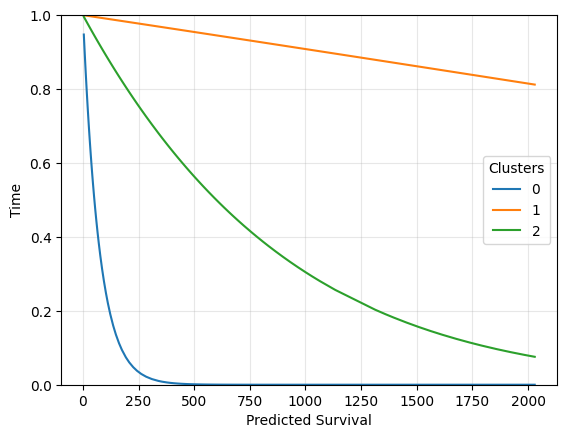

In [ ]:
pd.DataFrame(clusters, index = times_cluster).plot()
plt.grid(alpha = 0.3)
plt.ylim(0, 1)
plt.legend(title = 'Clusters')
plt.xlabel('Predicted Survival')
plt.ylabel('Time')

**DSM replication results**

In [ ]:
from dsm import DeepSurvivalMachines

In [ ]:
print(x_train,t_train,e_train)

[[ 0.43508246  0.09771103  0.26923193 ... -0.50634173  0.72025387
  -0.39928626]
 [ 0.79466963 -1.39001299  1.38898599 ...  1.97495078 -1.38839934
  -0.39928626]
 [-1.82665879 -0.64615098  0.55820072 ... -0.50634173  0.72025387
  -0.39928626]
 ...
 [ 1.01726839 -1.39001299 -0.74215884 ... -0.50634173  0.72025387
  -0.39928626]
 [ 0.5714879  -0.64615098  1.38898599 ... -0.50634173  0.72025387
  -0.39928626]
 [ 1.0402924   0.09771103 -0.63379554 ... -0.50634173  0.72025387
  -0.39928626]] [1986  124   42 ...   59   44   56] [0 1 1 ... 1 1 1]


In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [], [100], [100, 100] ]
             }
params = ParameterGrid(param_grid)

models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train, t_train, e_train, iters = 100, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(x_val, t_val, e_val), model]])
best_model = min(models)
model_dsm = best_model[0][1]

  6%|▌         | 6/100 [00:02<00:35,  2.65it/s]


In [ ]:

# Predict risk scores for new data
risk_scores_dsm = model_dsm.predict_risk(x_test,  times_ddh.tolist())

survival_probs_dsm = model_dsm.predict_survival(x_test,  times_ddh.tolist())

In [ ]:
print(risk_scores_dsm.shape)
print(survival_probs_dsm.shape)

(1821, 3)
(1821, 3)


In [ ]:
### Evaluation
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, risk_scores_dsm[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, survival_probs_dsm, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, risk_scores_dsm[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.5966816364591261
Brier Score: 0.16242642673794808
ROC AUC  0.6103577758085955 

For 0.5 quantile,
TD Concordance Index: 0.5724168029456322
Brier Score: 0.3266091778790099
ROC AUC  0.5722736611423092 

For 0.75 quantile,
TD Concordance Index: 0.5344331324108427
Brier Score: 0.49392130244092575
ROC AUC  0.4950270211585322 



**DCM replication results**

In [ ]:
sys.path.append('/content/gdrive/My Drive/NeuralSurvivalClustering/auton-survival/')
from auton_survival.models.dcm import DeepCoxMixtures
from auton_survival.preprocessing import Preprocessor
processor = Preprocessor()
x_train_dcm = x_train
t_train_dcm = t_train
e_train_dcm = e_train
x_dev_dcm = x_dev
t_dev_dcm = t_dev
e_dev_dcm = e_dev
x_test_dcm = x_test
t_test_dcm = t_test

In [ ]:
layers = [[50, 50], [50, 50, 50],  [100, 100], [100, 100, 100]]
param_grid = {
            'k' : [1,2],
            'layers':layers,
            'gamma': [5,10],
            'smoothing_factor': [0.001,0.01,0.1],
            'use_activation': [True, False],
            }
params = ParameterSampler(param_grid, 20, random_state = 42)


models = []
for param in params:
    model = DeepCoxMixtures(k = param['k'], gamma = param['gamma'], smoothing_factor = param['smoothing_factor'],
                                use_activation = param['use_activation'])
    # The fit method is called to train the model
   # try:
    model.fit(x_train_dcm, t_train_dcm, e_train_dcm, val_data = (x_dev_dcm, t_dev_dcm, e_dev_dcm),learning_rate = 1e-2)
    survival_probs = model.predict_survival(x_train_dcm,t_train_dcm)
    log_likelihood = np.log(survival_probs + 1e-8)
    nll_loss = -log_likelihood.mean().item()

    models.append([nll_loss,model])
   # except:
        #print("WARNING: Nan Value Observed")
       # pass



  0%|          | 0/1 [00:00<?, ?it/s]/content/gdrive/My Drive/NeuralSurvivalClustering/auton-survival/auton_survival/models/dcm/dcm_utilities.py:105: RuntimeWarning: invalid value encountered in log
  probs = gates+np.log(event_probs)
100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


In [ ]:
sort_models = sorted(models, key = lambda x: x[0])
print(sort_models)

[[0.5349742228098237, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781414cc01d0>], [0.5628510234113662, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781414197f90>], [0.6057448697285398, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781414290850>], [0.6057448697285398, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781414206810>], [0.6111032019573572, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781414bc6d90>], [0.6171558680232903, <auton_survival.models.dcm.DeepCoxMixtures object at 0x78141415d210>], [0.6171558680232903, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781414bd4050>], [0.6171558680232903, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781414be7210>], [0.6358346565129571, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7814142a1910>], [0.6358346565129571, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781414bc4910>], [0.6358346565129571, <auton_survival.models.dcm.DeepCoxMixtures object at 0x781

In [ ]:
model_dcm = sort_models[0][1]

In [ ]:

survival_probs_dcm = model_dcm.predict_survival(x_test, times_ddh.tolist())
risk_scores_dcm = 1-survival_probs_dcm

In [ ]:
print(risk_scores_dcm.shape)
print(survival_probs_dcm.shape )
print(survival_probs_dcm )
print(risk_scores_dcm)

(1821, 3)
(1821, 3)
[[0.91440106 0.91440106 0.91440106]
 [0.94262339 0.94262339 0.94262339]
 [0.88980383 0.88980383 0.88980383]
 ...
 [0.9895697  0.9895697  0.9895697 ]
 [0.95060118 0.95060118 0.95060118]
 [0.89064473 0.89064473 0.89064473]]
[[0.08559894 0.08559894 0.08559894]
 [0.05737661 0.05737661 0.05737661]
 [0.11019617 0.11019617 0.11019617]
 ...
 [0.0104303  0.0104303  0.0104303 ]
 [0.04939882 0.04939882 0.04939882]
 [0.10935527 0.10935527 0.10935527]]


In [ ]:
### Evaluation
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, risk_scores_dcm[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, survival_probs_dcm, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, risk_scores_dcm[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.6705173688892699
Brier Score: 0.13016975622865787
ROC AUC  0.6761608329641116 

For 0.5 quantile,
TD Concordance Index: 0.6163866956057419
Brier Score: 0.251758858603244
ROC AUC  0.6217737296260786 

For 0.75 quantile,
TD Concordance Index: 0.5909133696227267
Brier Score: 0.3818718906432632
ROC AUC  0.589863446645275 



In [ ]:
model_dcm.fit(x_train, t_train, e_train)

posterior_probs = model_dcm.predict_latent_z(x_train)




100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(posterior_probs)
#print(len(posterior_probs))
#print(t_train.shape)
#print(e_train.shape)
#print(clusters.shape)

#print(x_test_cluster)
#print(x_test_cluster.shape)


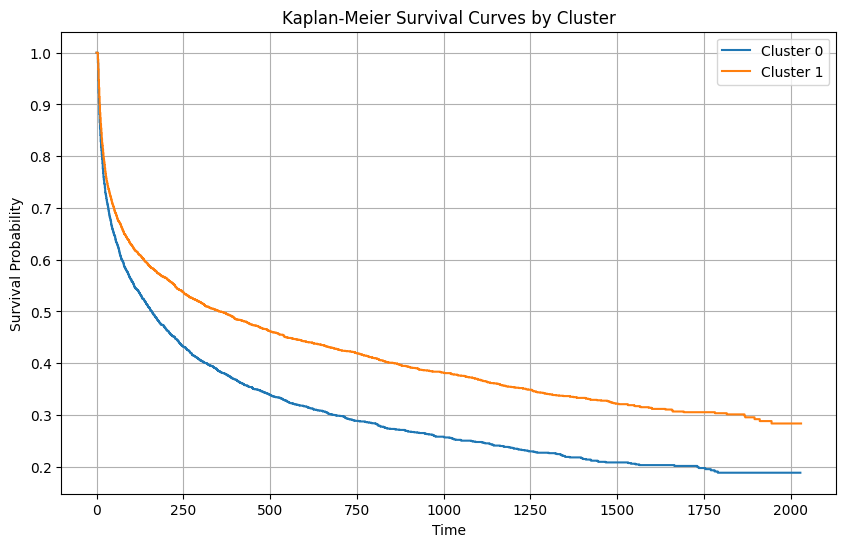

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import numpy as np

T = np.array(t_train)
E = np.array(e_train)

# Number of clusters from k-means
k = np.unique(clusters).shape[0]

# Create plot
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for cluster_id in range(k):
    idx = (clusters == cluster_id)
    if np.sum(idx) == 0:
        continue  # skip empty cluster

    kmf.fit(T[idx], event_observed=E[idx], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


**Sumo-net**

In [ ]:
ss = MinMaxScaler().fit(t_train.reshape(-1, 1))
t_train_ddh = ss.transform(t_train.reshape(-1, 1)).flatten()
t_dev_ddh = ss.transform(t_dev.reshape(-1, 1)).flatten()
t_val_ddh = ss.transform(t_val.reshape(-1, 1)).flatten()
times_ddh = ss.transform(np.array(times).reshape(-1, 1)).flatten()

In [ ]:
layers = [[50], [50, 50], [50, 50, 50], [100], [100, 100], [100, 100, 100]]
param_grid = {
            'learning_rate' : [1e-3, 1e-4],
            'layers_surv': layers,
            'layers' : layers,
            'batch': [100, 250],
            }
params = ParameterSampler(param_grid, 5, random_state = 42)

In [ ]:
sys.path.append('/content/gdrive/My Drive/NeuralSurvivalClustering/Sumo/')

In [ ]:
from sumo import SuMo
models = []
for param in params:
    model = SuMo(layers = param['layers'], layers_surv = param['layers_surv'])
    # The fit method is called to train the model
    model.fit(x_train, t_train_ddh, e_train, n_iter = 1000, bs = param['batch'],
            lr = param['learning_rate'], val_data = (x_dev, t_dev_ddh, e_dev))
    nll = model.compute_nll(x_val, t_val_ddh, e_val)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

best_model = min(models, key = lambda x: x[0])
model = best_model[1]

Loss: -0.719:   6%|▌         | 55/1000 [00:21<06:13,  2.53it/s]


In [ ]:
out_risk = model.predict_risk(x_test, times_ddh.tolist())
out_survival = model.predict_survival(x_test, times_ddh.tolist())
print(out_risk)
print(out_survival)
print(out_risk.shape)
print(out_survival.shape)

[[0.10512443 0.27583809 0.51603086]
 [0.14671573 0.27017324 0.47660161]
 [0.18457961 0.38585731 0.56238803]
 ...
 [0.00490234 0.13878997 0.46224004]
 [0.16483706 0.39064901 0.5134339 ]
 [0.21813538 0.41654968 0.53154391]]
[[0.89487557 0.72416191 0.48396914]
 [0.85328427 0.72982676 0.52339839]
 [0.81542039 0.61414269 0.43761197]
 ...
 [0.99509766 0.86121003 0.53775996]
 [0.83516294 0.60935099 0.4865661 ]
 [0.78186462 0.58345032 0.46845609]]
(1821, 3)
(1821, 3)


In [ ]:

cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.7639803213324902
Brier Score: 0.11559586652651312
ROC AUC  0.7762472308373948 

For 0.5 quantile,
TD Concordance Index: 0.7167805390292925
Brier Score: 0.1855761651948625
ROC AUC  0.7379276811395699 

For 0.75 quantile,
TD Concordance Index: 0.6839114318080752
Brier Score: 0.20902494939450617
ROC AUC  0.7353579097203793 



# **Deep Hit, DeepSurv, Cox **

In [ ]:
!pip install pycox torchtuples


In [ ]:
from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from torchtuples import optim

from pycox.models import DeepHitSingle
from pycox.models.loss import DeepHitSingleLoss
from pycox.evaluation import EvalSurv
from torchtuples import optim
import torchtuples as tt
import numpy as np
import torch

# Recall Datasets for value

from nsc import datasets
x, t, e, columns = datasets.load_dataset('SUPPORT')
from sklearn.model_selection import train_test_split

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size=0.2, random_state=42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size=0.2, random_state=42)
x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size=0.5, random_state=42)

labtrans = DeepHitSingle.label_transform(100)

y_train = labtrans.fit_transform(t_train, e_train)
y_dev = labtrans.transform(t_dev, e_dev)
y_val = labtrans.transform(t_val, e_val)
y_test = labtrans.transform(t_test, e_test)

x_train = x_train.astype('float32')
x_dev = x_dev.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
print("Check X_train shape.", x_train.shape)


Check X_train shape. (5827, 44)


In [ ]:
# DeepHit Model traning
# Check Input
print("Input shape:", x_train.shape)

# in-features
in_features = x_train.shape[1]
num_nodes = [100, 100]
out_features = labtrans.out_features

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, activation=torch.nn.ReLU)

model = DeepHitSingle(net, optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

# train
model.fit(
    x_train.astype('float32'), y_train,
    batch_size=256,
    epochs=100,
    val_data=(x_dev.astype('float32'), y_dev),
    verbose=True
)

Input shape: (5827, 44)
0:	[0s / 0s],		train_loss: 0.9951,	val_loss: 0.9882
1:	[0s / 1s],		train_loss: 0.9320,	val_loss: 0.9581
2:	[0s / 2s],		train_loss: 0.8965,	val_loss: 0.9437
3:	[0s / 3s],		train_loss: 0.8717,	val_loss: 0.9339
4:	[0s / 3s],		train_loss: 0.8476,	val_loss: 0.9317
5:	[0s / 4s],		train_loss: 0.8273,	val_loss: 0.9222
6:	[0s / 5s],		train_loss: 0.8081,	val_loss: 0.9256
7:	[0s / 5s],		train_loss: 0.7870,	val_loss: 0.9270
8:	[0s / 6s],		train_loss: 0.7689,	val_loss: 0.9382
9:	[0s / 6s],		train_loss: 0.7494,	val_loss: 0.9279
10:	[0s / 6s],		train_loss: 0.7316,	val_loss: 0.9447
11:	[0s / 7s],		train_loss: 0.7124,	val_loss: 0.9278
12:	[0s / 7s],		train_loss: 0.6978,	val_loss: 0.9404
13:	[0s / 8s],		train_loss: 0.6782,	val_loss: 0.9444
14:	[0s / 8s],		train_loss: 0.6634,	val_loss: 0.9617
15:	[0s / 8s],		train_loss: 0.6467,	val_loss: 1.0006
16:	[0s / 9s],		train_loss: 0.6359,	val_loss: 0.9959
17:	[0s / 9s],		train_loss: 0.6225,	val_loss: 1.0280
18:	[0s / 10s],		train_loss: 0.6

In [ ]:
# Predict survival function for test data
surv_df = model.predict_surv_df(x_test)

# Transpose to get shape (num_samples, time_steps)
surv_probs_deephit = surv_df.T.values

# Compute risk scores as (1 - survival probability)
risk_scores_deephit = 1 - surv_probs_deephit

print("Survival shape:", surv_probs_deephit.shape)
print("Risk shape:", risk_scores_deephit.shape)
print(surv_probs_deephit)
print(risk_scores_deephit)

# Get the model's internal time bin cut points
cut_times = model.duration_index

# Find the indices of the closest time bins for each evaluation horizon
idxs = [np.abs(cut_times - t).argmin() for t in times_ddh]

# Extract survival probabilities and risk scores at selected evaluation times
surv_probs_sampled = surv_probs_deephit[:, idxs]
risk_scores_sampled = risk_scores_deephit[:, idxs]

print(surv_probs_sampled.shape)  # Expected: (num_samples, 3)
print(risk_scores_sampled.shape)  # Expected: (num_samples,_


Survival shape: (1821, 100)
Risk shape: (1821, 100)
[[9.9672908e-01 5.8365285e-01 5.3333688e-01 ... 4.5846701e-03
  4.5738220e-03 1.7130375e-03]
 [9.9972731e-01 9.2737615e-01 8.9114946e-01 ... 1.7222762e-03
  5.2356720e-04 3.8647652e-04]
 [9.9998063e-01 9.7357959e-01 8.0035353e-01 ... 7.4820280e-02
  7.4819684e-02 9.9271536e-04]
 ...
 [9.9999970e-01 9.9964422e-01 9.9485016e-01 ... 2.2292733e-03
  3.9035082e-04 3.2788515e-04]
 [9.9809897e-01 9.4067526e-01 9.0544558e-01 ... 2.3969245e-01
  2.0032525e-03 1.7096400e-03]
 [9.9999964e-01 9.1052139e-01 8.1520951e-01 ... 3.7038416e-01
  3.3566290e-01 6.4778328e-04]]
[[3.2709241e-03 4.1634715e-01 4.6666312e-01 ... 9.9541533e-01
  9.9542618e-01 9.9828696e-01]
 [2.7269125e-04 7.2623849e-02 1.0885054e-01 ... 9.9827772e-01
  9.9947643e-01 9.9961352e-01]
 [1.9371510e-05 2.6420414e-02 1.9964647e-01 ... 9.2517972e-01
  9.2518032e-01 9.9900728e-01]
 ...
 [2.9802322e-07 3.5578012e-04 5.1498413e-03 ... 9.9777073e-01
  9.9960965e-01 9.9967211e-01]
 [1.901

In [ ]:
# Result Data sets
from sksurv.metrics import (
    concordance_index_ipcw,
    brier_score,
    cumulative_dynamic_auc
)
import numpy as np

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                    dtype=[('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                   dtype=[('e', bool), ('t', float)])

# Evaluation
cis = []
brs = []
roc_auc = []

for i, t_q in enumerate(times):
    # Time-dependent C-index
    ci = concordance_index_ipcw(et_train, et_test, risk_scores_sampled[:, i], t_q)[0]
    cis.append(ci)

    # Time-dependent ROC AUC
    auc = cumulative_dynamic_auc(et_train, et_test, risk_scores_sampled[:, i], t_q)[0]
    roc_auc.append(auc)

# Brier Score for all times at once
bs_all = brier_score(et_train, et_test, surv_probs_sampled, times)[1]
brs.append(bs_all)

# Display
for i, q in enumerate(horizons):
    print(f"For quantile q={q} (t={times[i]:.2f}):")
    print("TD Concordance Index:", cis[i])
    print("Brier Score:", brs[0][i])
    print("ROC AUC:", roc_auc[i], "\n")


For quantile q=0.25 (t=15.00):
TD Concordance Index: 0.367513049443188
Brier Score: 0.16277205886063173
ROC AUC: [0.36399092] 

For quantile q=0.5 (t=59.00):
TD Concordance Index: 0.3991658278125024
Brier Score: 0.32572944573376955
ROC AUC: [0.39651418] 

For quantile q=0.75 (t=253.00):
TD Concordance Index: 0.41493131631821706
Brier Score: 0.49415952789763334
ROC AUC: [0.40883495] 



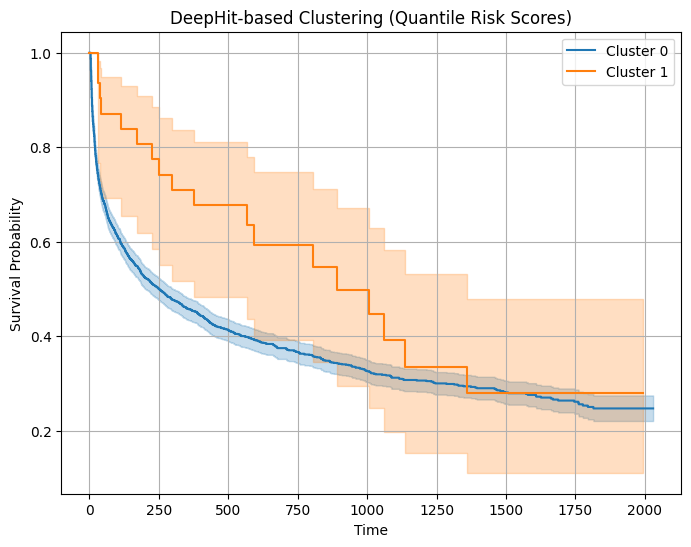

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(risk_scores_sampled)

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    kmf.fit(t_test[mask], e_test[mask], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function()

plt.title("DeepHit-based Clustering (Quantile Risk Scores)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()


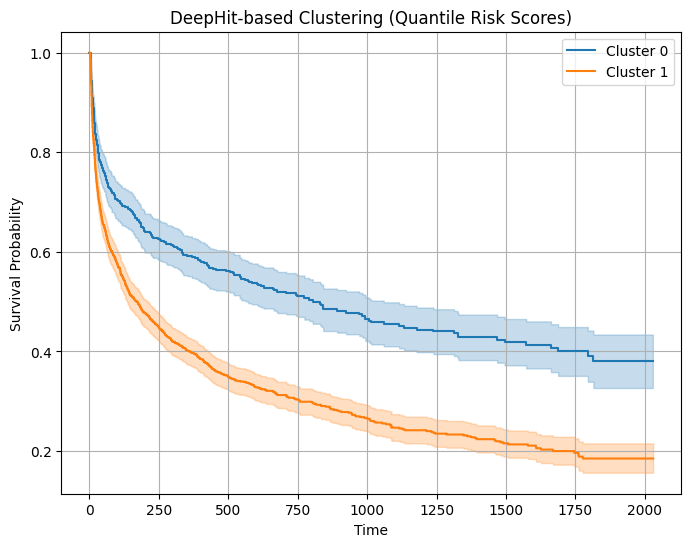

In [ ]:
# Clusring for surv_probs_deephit
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(surv_probs_deephit)

# Step 2: KM Curve
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    kmf.fit(t_test[mask], e_test[mask], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function()

plt.title("DeepHit-based Clustering (Quantile Risk Scores)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()


DeepSurv

In [ ]:
# DeepSurv
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torchtuples as tt
import torch
import numpy as np
# Convert time to float32 and features to float32
x_train = x_train.astype('float32')
x_dev = x_dev.astype('float32')
x_test = x_test.astype('float32')

# Stack time and event into one tensor
y_train = np.array([t_train, e_train]).T
y_dev = np.array([t_dev, e_dev]).T

# Network
in_features = x_train.shape[1]
net = tt.practical.MLPVanilla(in_features, [100, 100], 1, activation=torch.nn.ReLU)

# Model
model = CoxPH(net, tt.optim.Adam)

# Fit
model.fit(x_train, (t_train, e_train), batch_size=256, epochs=100,
          val_data=(x_dev, (t_dev, e_dev)), verbose=True)

0:	[0s / 0s],		train_loss: 4.9708,	val_loss: 5.9301
1:	[0s / 0s],		train_loss: 4.8539,	val_loss: 5.9070
2:	[0s / 1s],		train_loss: 4.8197,	val_loss: 5.8920
3:	[0s / 1s],		train_loss: 4.8012,	val_loss: 5.8905
4:	[0s / 1s],		train_loss: 4.7770,	val_loss: 5.8870
5:	[0s / 2s],		train_loss: 4.7585,	val_loss: 5.8868
6:	[0s / 2s],		train_loss: 4.7375,	val_loss: 5.8852
7:	[0s / 3s],		train_loss: 4.7171,	val_loss: 5.8939
8:	[0s / 3s],		train_loss: 4.6982,	val_loss: 5.8916
9:	[0s / 3s],		train_loss: 4.6784,	val_loss: 5.8975
10:	[0s / 4s],		train_loss: 4.6561,	val_loss: 5.8964
11:	[0s / 4s],		train_loss: 4.6398,	val_loss: 5.9109
12:	[0s / 4s],		train_loss: 4.6166,	val_loss: 5.9161
13:	[0s / 4s],		train_loss: 4.5997,	val_loss: 5.9440
14:	[0s / 5s],		train_loss: 4.5719,	val_loss: 5.9306
15:	[0s / 5s],		train_loss: 4.5569,	val_loss: 5.9562
16:	[0s / 5s],		train_loss: 4.5301,	val_loss: 5.9807
17:	[0s / 5s],		train_loss: 4.5050,	val_loss: 5.9936
18:	[0s / 6s],		train_loss: 4.4944,	val_loss: 6.0341
19:

In [ ]:
model.compute_baseline_hazards()
surv_df = model.predict_surv_df(x_test)
risk_scores = -model.predict(x_test).reshape(-1)

In [ ]:
from sksurv.metrics import (
    concordance_index_ipcw,
    brier_score,
    cumulative_dynamic_auc
)

# Structured format
et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                    dtype=[('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                   dtype=[('e', bool), ('t', float)])

# Quantiles
times = np.array(np.quantile(t_train[e_train != 0], [0.25, 0.5, 0.75]))

# Risk scores for DeepSurv
risk_scores = -model.predict(x_test).reshape(-1)  # higher = riskier
surv_probs = surv_df.T.values  # shape (n_samples, n_times)

# Match survival probabilities to selected time indices
cut_times = surv_df.index.values  # model's internal time points
idxs = [np.abs(cut_times - t).argmin() for t in times]
surv_sampled = surv_probs[:, idxs]
risk_sampled = 1 - surv_sampled

# Evaluate
cis = []
roc_auc = []
for i, t in enumerate(times):
    ci = concordance_index_ipcw(et_train, et_test, risk_sampled[:, i], t)[0]
    auc = cumulative_dynamic_auc(et_train, et_test, risk_sampled[:, i], t)[0]
    cis.append(ci)
    roc_auc.append(auc)

brs = brier_score(et_train, et_test, surv_sampled, times)[1]

# Display
for i, t in enumerate(times):
    print(f"Quantile q{i+1} (t={t:.2f}):")
    print(f"  TD Concordance Index: {cis[i]}")
    print(f"  Brier Score: {brs[i]}")
    print(f"  ROC AUC: {roc_auc[i]}\n")


Quantile q1 (t=15.00):
  TD Concordance Index: 0.6603800683822978
  Brier Score: 0.16226659805928667
  ROC AUC: [0.66424014]

Quantile q2 (t=59.00):
  TD Concordance Index: 0.646741511408974
  Brier Score: 0.26198864967380886
  ROC AUC: [0.66610464]

Quantile q3 (t=252.00):
  TD Concordance Index: 0.6366106583051749
  Brier Score: 0.2970518555309672
  ROC AUC: [0.67139798]



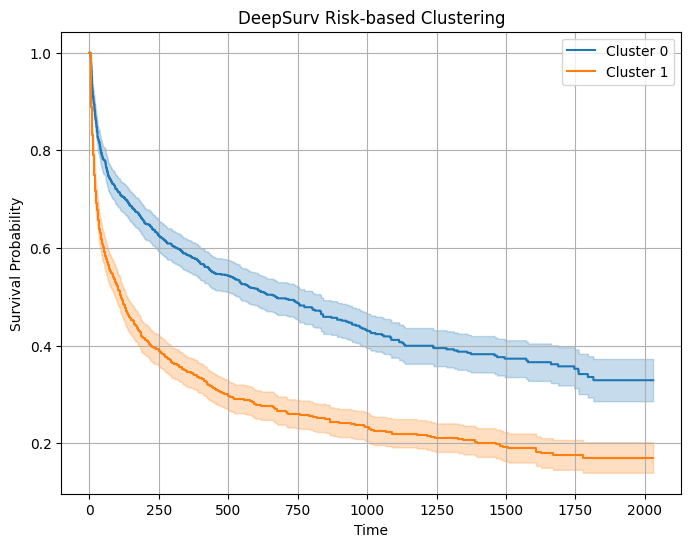

Silhouette Score: 0.52686894


In [ ]:
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# Step 1: KMeans clustering on risk scores
risk_scores_reshape = risk_scores.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(risk_scores_reshape)

# Step 2: Plot Kaplan-Meier curves by cluster
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    kmf.fit(t_test[mask], e_test[mask], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function()

plt.title("DeepSurv Risk-based Clustering")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(risk_scores_reshape, clusters)
print("Silhouette Score:", sil_score)


Cox Spritter

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
# CosPHFitter

# 1. Standardize
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 2. Remove low-variance features
selector = VarianceThreshold(threshold=1e-5)
x_train_filtered = selector.fit_transform(x_train_scaled)
x_test_filtered = selector.transform(x_test_scaled)

# 3. Remove high-correlation features
df_filtered = pd.DataFrame(x_train_filtered, columns=[f'x{i}' for i in range(x_train_filtered.shape[1])])
corr = df_filtered.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

df_train_final = df_filtered.drop(columns=to_drop).copy()
df_train_final['T'] = t_train
df_train_final['E'] = e_train

df_test_final = pd.DataFrame(x_test_filtered, columns=df_filtered.columns).drop(columns=to_drop).copy()

# 4. Fit Cox with regularization
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_train_final, duration_col='T', event_col='E')

<lifelines.CoxPHFitter: fitted with 5827 total observations, 1874 right-censored observations>

In [ ]:
# Predict risk scores using final filtered test set
risk_scores_cox = -cph.predict_partial_hazard(df_test_final).values  # higher = riskier
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc

# Define evaluation time points
times = np.array(np.quantile(t_train[e_train != 0], [0.25, 0.5, 0.75]))

# Prepare structured arrays
et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                    dtype=[('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                   dtype=[('e', bool), ('t', float)])

# Evaluate
cis = []
roc_auc = []
for i, t in enumerate(times):
    ci = concordance_index_ipcw(et_train, et_test, risk_scores_cox, t)[0]
    auc = cumulative_dynamic_auc(et_train, et_test, risk_scores_cox, t)[0]
    cis.append(ci)
    roc_auc.append(auc)

# Display results
for i, t in enumerate(times):
    print(f"CoxPH (final) at quantile q{i+1} (t={t:.2f}):")
    print(f"  TD Concordance Index: {cis[i]:.4f}")
    print(f"  ROC AUC: {float(roc_auc[i]):.4f}")


CoxPH (final) at quantile q1 (t=15.00):
  TD Concordance Index: 0.2991
  ROC AUC: 0.2927
CoxPH (final) at quantile q2 (t=59.00):
  TD Concordance Index: 0.3320
  ROC AUC: 0.3125
CoxPH (final) at quantile q3 (t=252.00):
  TD Concordance Index: 0.3331
  ROC AUC: 0.2824


<ipython-input-56-aa8296506b6d>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  ROC AUC: {float(roc_auc[i]):.4f}")


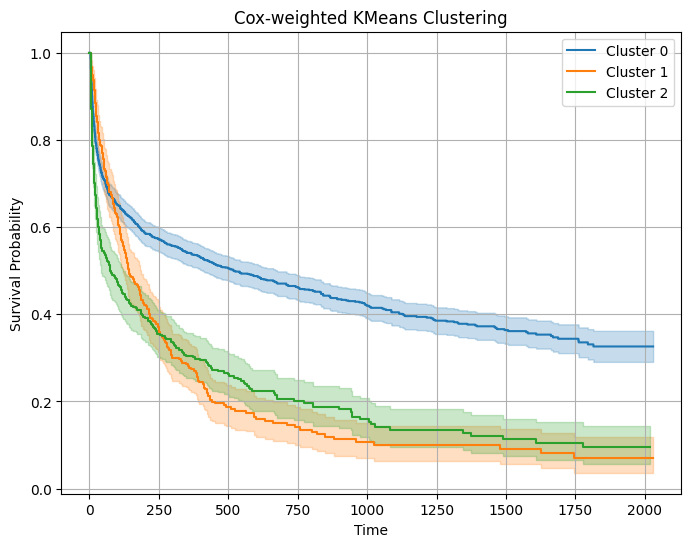

In [ ]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

risk_scores = -cph.predict_partial_hazard(df_test_final).values.reshape(-1, 1)

scaler = StandardScaler()
x_features = scaler.fit_transform(df_test_final.values)  # only features
x_combined = np.hstack([x_features, risk_scores])  # [features | risk score]

kmeans = KMeans(n_clusters=3,  random_state=42)
clusters = kmeans.fit_predict(x_combined,sample_weight = e_test)

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

T = t_test
E = e_test
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    kmf.fit(T[mask], E[mask], label=f"Cluster {cluster_id}")
    kmf.plot_survival_function()

plt.title("Cox-weighted KMeans Clustering")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()
